### 2024/02/20 機械学習モデルを用いて線種判定

In [9]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from preprocessed_data_plusinfo import PreprocessedDataPlusInfo
import umap

from sklearn.svm import OneClassSVM

from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from view_function import ViewFunction
vf = ViewFunction()

##### ▶指導者のみからコサイン類似度の分布を作成

In [46]:
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)
# --- 指導者 --- #
box_t_info = drawing_info.query('is_preanalysis_box == 1').query('name == "saito"')
# bag_t_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "saito"')

# --- 学習者 --- #
# box_a_info = drawing_info.query('is_preanalysis_box == 1').query('name == "井原亜利紗"')
# bag_a_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "井原亜利紗"')
# box_b_info = drawing_info.query('is_preanalysis_box == 1').query('name == "高田麻央"')
# bag_b_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "高田麻央"')
# box_c_info = drawing_info.query('is_preanalysis_box == 1').query('name == "冨山恭子"')
# bag_c_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "冨山恭子"')

# ---データ --- #
box_t = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(box_t_info['url'], box_t_info['rotate_type'])]
# bag_t = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(bag_t_info['url'], bag_t_info['rotate_type'])]

# box_a = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(box_a_info['url'], box_a_info['rotate_type'])]
# box_b = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(box_b_info['url'], box_b_info['rotate_type'])]
# box_c = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(box_c_info['url'], box_c_info['rotate_type'])]
# bag_a = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(bag_a_info['url'], bag_a_info['rotate_type'])]
# bag_b = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(bag_b_info['url'], bag_b_info['rotate_type'])]
# bag_c = [PreprocessedDataPlusInfo(url, rtype) for url, rtype in zip(bag_c_info['url'], bag_c_info['rotate_type'])]

df_box_t = pd.concat([box_t[0].df_addinfo, box_t[1].df_addinfo, box_t[2].df_addinfo, box_t[3].df_addinfo], axis=0)

In [53]:
df_box_t = pd.concat([box_t[0].df_addinfo, box_t[1].df_addinfo, box_t[2].df_addinfo, box_t[3].df_addinfo], axis=0)

##### ▶コサイン類似度を有効桁数4桁で四捨五入

In [54]:
import sigfig
from decimal import *

# 齊藤先生のcossimのみのリストを生成
cossims_rounded = []
for cossims in df_box_t['cos_sim']:
    cossims_rounded.append([round(sim, 4) for sim in cossims])

df_box_t['cossim_lerp943_rounded4'] = cossims_rounded

In [58]:
df_box_t.to_pickle('../temp/20240301_box_t_rounded4_cossim.pkl')

In [4]:
# 線形補完した場合としない場合のコサイン類似度を保存

# df_cossim_lerp = pd.DataFrame({'cossim_box_t_rounded4': box_t_cossim_rounded})
# df_cossim_lerp.to_csv('../temp/20240221_box_t_cossim_lerp943.csv')

# df_cossim_org = pd.DataFrame({'cossim_box_t_rounded4': box_t_cossim_rounded})
# df_cossim_org.to_csv('../temp/20240221_box_t_cossim_notlerp.csv')

In [55]:
# cossim_1 = [value for value in box_t_cossim_rounded if value == 1]
# cossim_under_1 = [value for value in box_t_cossim_rounded if value < 1]

In [5]:
# plt.scatter(range(len(df_cossim_org['cossim_box_t_rounded4'])), df_cossim_org['cossim_box_t_rounded4'], marker='.', alpha=0.2)
# plt.hist(df_cossim_org['cossim_box_t_rounded4'], bins=100)
# plt.boxplot(df_cossim_org['cossim_box_t_rounded4'])
# print(len(df_cossim_org['cossim_box_t_rounded4']))

In [4]:
# COSSIM_PLOT_COLOR = '#47C96D'
# LINE_WIDTH = 1
# def generate_cossim_plot(df):
#     plt.rcParams['font.family'] = 'MS Gothic'
#     FIG_SIZE = (10, 5)
#     for drawing_id, cos_sim, stroke_id in zip(df['drawing_id'], df['cos_sim_org'], df['stroke_id']):
#         fig, ax = plt.subplots(figsize=(FIG_SIZE[0],FIG_SIZE[1]))
#         ax.set_ylim(-1.2, 1.2)
#         ax.set_xlim(0, 100)
        
#         ax.set_xlabel('線形補完後の座標の順番 [番目]')
#         ax.set_ylabel('コサイン類似度')
#         ax.grid(True, alpha=0.2)
#         title = f'cossim_{drawing_id}_{stroke_id}'
#         ax.set_title(title)
#         ax.plot(range(len(cos_sim)), cos_sim, color=COSSIM_PLOT_COLOR, linewidth=LINE_WIDTH, alpha=1, )
#         ax.scatter(range(len(cos_sim)), cos_sim, marker='.', color=COSSIM_PLOT_COLOR, alpha=1, )
#         plt.savefig(f'../temp/test/{title}.png')
#         plt.show()
#         plt.close()
        
#         print(drawing_id, ' | ', stroke_id)
    
#     return

##### ▶外れ値を検出

In [21]:
# データ読み込み
cossim_boxt = pd.read_csv('../temp/20240221_box_t_cossim_lerp943.csv', index_col=0)['cossim_box_t_rounded4']

##### ▶各ストロークごとに、コサイン類似度が大きい箇所から5箇所だけ、順番に記録

In [2]:
cossim_boxt = pd.read_pickle('../temp/20240301_box_t_rounded4_cossim.pkl')

In [6]:
# 各ストロークごとに、折り返し点が顕著な箇所（コサイン類似度が大きい箇所）を5点求める
# ソートの順番
# 1. まず、コサイン類似度を昇順に並べ替える
# 2. 同じコサイン類似度の値があった場合、その後、座標の順番を昇順に並べ替える
MAX_POINTS = 5
cossim_cnums = []
for did, sid, cossims in zip(cossim_boxt['drawing_id'], cossim_boxt['stroke_id'], cossim_boxt['cossim_lerp943_rounded4']):
    # [cossim, 座標の順番]を1つの要素とする2次元リストを生成
    cossim_cnum = [{'cossim': cossim, 'cnum': cnum} for cnum, cossim in enumerate(cossims)]
    # print(cossim_coordnums)
    # cossim, 座標の順番 の順で昇順に並べ替え
    sorted_cossim_cnum = sorted(cossim_cnum, key=lambda x: (x['cossim'], x['cnum']))[:MAX_POINTS]
    cossim_cnums.append(sorted_cossim_cnum)

In [8]:
cossim_boxt['cossim_cnums_head5'] = cossim_cnums

##### ①コサイン類似度を小さい順に並べ替える操作

In [44]:
MAX_POINTS = 5
RANGE_NUM = 10  # 時系列データを区切る区間の数

MAX_COSSIM =  1
MIN_COSSIM = -1
MAX_CNUM = 940
MIN_CNUM = 0

cossim_cnum_merges = []
for dicts in cossim_boxt['cossim_cnums_head5']:
    cossim_cnum_merge = []
    for i in range(len(dicts)):
        # 正規化 & 有効桁数を3-4桁に
        cossim_norm = (dicts[i]['cossim'] - MIN_COSSIM) / (MAX_COSSIM - MIN_COSSIM)
        cossim_cnum_merge.append(round(cossim_norm, 4))
        cnum_norm = (dicts[i]['cnum'] - MIN_CNUM) / (MAX_CNUM - MIN_CNUM)
        cossim_cnum_merge.append(round(cnum_norm, 3))
    cossim_cnum_merges.append(cossim_cnum_merge)

cossim_boxt['cossim_cnums_head5_merge'] = cossim_cnum_merges

##### ▶データの読み込み

In [3]:
cossim_boxt = pd.read_pickle('../temp/20240301_box_t_rounded4_cossim.pkl')

##### ▶時系列データを均等の区間に区切り、それぞれの区間での最小値を求め、その区間での代表値とする

In [49]:
SPLIT_NUM = 3  # 時系列データを区切る区間の数

MAX_COSSIM =  1
MIN_COSSIM = -1
MAX_CNUM = 940
MIN_CNUM = 0

cossim_split_mins = []
for cossims in cossim_boxt['cossim_lerp943_rounded4']:
    cossims_split = list(np.array_split(cossims, SPLIT_NUM))
    sim_mins = []
    for section in cossims_split:
        sim_mins.append(min(section))
    cossim_split_mins.append(sim_mins)

cossim_boxt['cossim_split10_mins'] = cossim_split_mins

In [50]:
strt = cossim_boxt.copy().query('shape_int == 1')
curv = cossim_boxt.copy().query('shape_int == 2')
comp = cossim_boxt.copy().query('shape_int == 3')
hatc = cossim_boxt.copy().query('shape_int == 4')

##### ▶UMAP

c:\Users\ispec\MyWorkSpace\python\drawing_2023\.venv\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


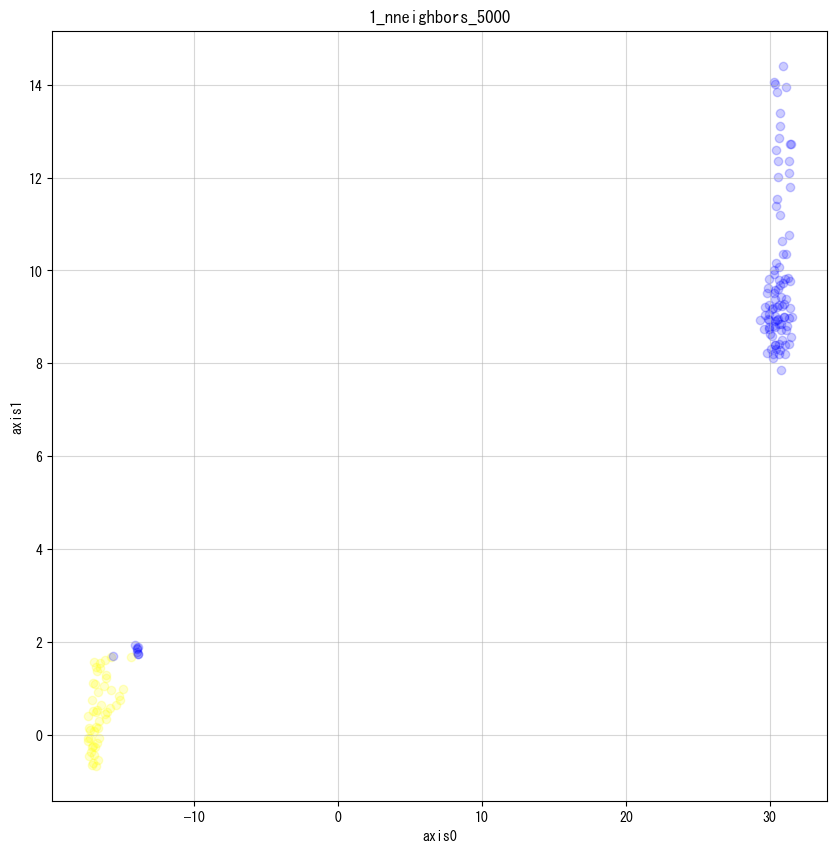

finish | 5000


In [51]:
# 入力データ
STRT_SPLIT_INDEX = 100
COMP_SPLIT_INDEX = 50
SEED = 1


train_data = pd.concat([strt[:STRT_SPLIT_INDEX], comp[:COMP_SPLIT_INDEX]], axis=0).sample(n=STRT_SPLIT_INDEX+COMP_SPLIT_INDEX, random_state=SEED)
train_nparray = np.array([np.array(nparr) for nparr in train_data['cossim_split10_mins'].to_numpy()])

for n_neighbors in [5000]:
    mapper = umap.UMAP(n_components=2, 
                        n_neighbors=n_neighbors,
                        min_dist=0.1,
                        metric = "euclidean"
                        )
    umap_result = mapper.fit_transform(train_nparray)

    train_data['axis0'] = umap_result[:, 0:1]
    train_data['axis1'] = umap_result[:, 1:2]
    
    title = f'1_nneighbors_{n_neighbors}'
    plt.rcParams['font.family'] = 'MS Gothic'
    FIG_SIZE = (10, 10)
    fig, ax = plt.subplots(figsize=(FIG_SIZE[0],FIG_SIZE[1]))
    ax.set_xlabel('axis0')
    ax.set_ylabel('axis1')
    ax.set_title(title)
    ax.grid(True, alpha=0.5)
    
    for ax0, ax1, shape_int in zip(train_data['axis0'], train_data['axis1'], train_data['shape_int']):
        if shape_int == 1:
            plt.scatter(ax0, ax1, color='blue', alpha=0.2)
        elif shape_int == 2:
            plt.scatter(ax0, ax1, color='green', alpha=0.2)
        elif shape_int == 3:
            plt.scatter(ax0, ax1, color='yellow', alpha=0.2)
        else:
            plt.scatter(ax0, ax1, color='black', alpha=0.2)
            
    # plt.scatter(train_data['axis0'], train_data['axis1'], color='blue', alpha=0.5)
    # plt.savefig(f'{title}_scatter.png')
    plt.show()
    plt.close()
    
    train_data.to_csv(f'../temp/{title}.tsv', sep='\t', encoding='shift-jis')
    
    print(f'finish | {n_neighbors}')

##### ▶One Class SVM

In [4]:
# 入力データ
STRT_SPLIT_INDEX = 135
COMP_SPLIT_INDEX = 15
NU = COMP_SPLIT_INDEX / (STRT_SPLIT_INDEX + COMP_SPLIT_INDEX)
SEED = 1


train_data = pd.concat([strt[:STRT_SPLIT_INDEX], comp[:COMP_SPLIT_INDEX]], axis=0).sample(n=STRT_SPLIT_INDEX+COMP_SPLIT_INDEX, random_state=SEED)
train_nparray = np.array([np.array(nparr) for nparr in train_data['cossim_split10_mins'].to_numpy()])

test_data = pd.concat([strt[STRT_SPLIT_INDEX:], comp[COMP_SPLIT_INDEX:]], axis=0)
test_nparray = np.array([np.array(nparr) for nparr in test_data['cossim_split10_mins'].to_numpy()])

# 推論
#OC-SVMをインスタンス化。トレーニングデータには1個異常値が含ませているので、nu=0.01とする
clf = OneClassSVM(nu = NU, gamma='auto')
#トレーニングの実行
clf.fit(train_nparray)
#予測の実行
pred = clf.predict(test_nparray)
test_data['ocsvm_pred'] = pred

#-1(異常値)となったデータのインデックスを表示
pred

In [1]:
# import requests

# drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)

# for did, sid, pred in zip(test_data['drawing_id'], test_data['stroke_id'], test_data['ocsvm_pred']):
#     if pred == 1:
#         label = 'normal'
#     else:
#         label = 'exception'
        
#     url = drawing_info.query('drawing_id == @did')['url'].iloc[-1]
#     url_graph = url.replace('/strokes/pointlists', '') +  f'/strokes/{sid}/graph'
#     file_name = f'../temp/test/{did}_{sid}_' + label + '.jpg'
#     response = requests.get(url_graph, auth=('19t2003a', 'ireneRED77'))
#     image = response.content

#     with open(file_name, 'wb') as img:
#         img.write(image)
#     print('----------------')
#     print(file_name)
#     print(url_graph)

##### ▶t-SNE

finish | 40


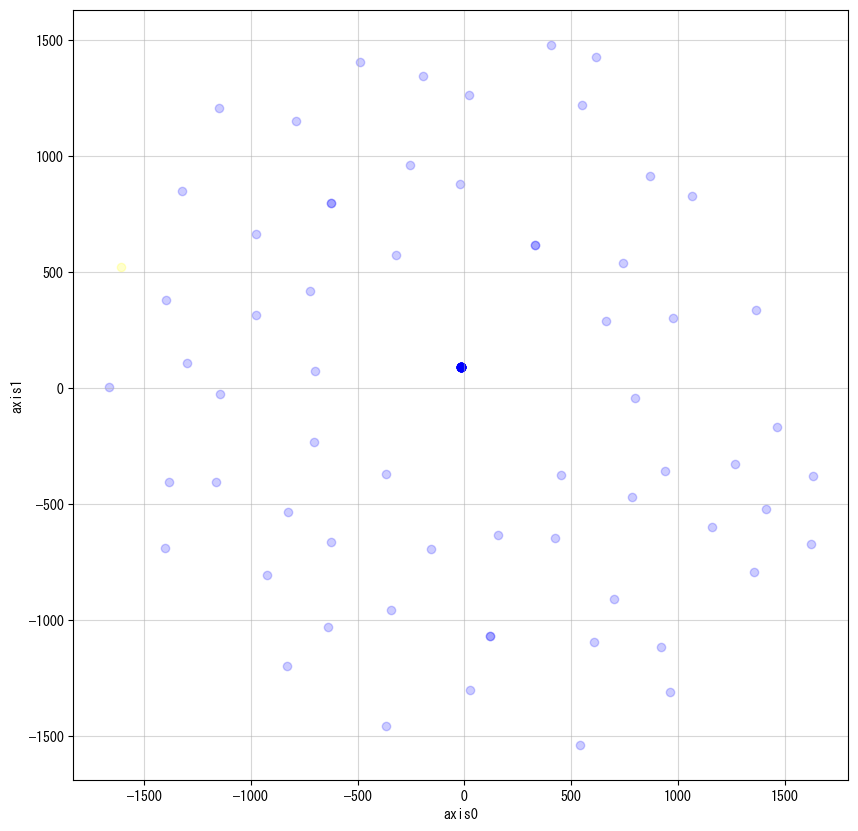

In [28]:
# 入力データ
STRT_SPLIT_INDEX = 100
COMP_SPLIT_INDEX = 1
SEED = 1


train_data = pd.concat([strt[:STRT_SPLIT_INDEX], comp[:COMP_SPLIT_INDEX]], axis=0).sample(n=STRT_SPLIT_INDEX+COMP_SPLIT_INDEX, random_state=SEED)
train_nparray = np.array([np.array(nparr) for nparr in train_data['cossim_split10_mins'].to_numpy()])

##### 調整可能パラメータ #####
perplexitys = [ i for i in range(5, 51, 5)]
perplexitys = [ 40 ]


##### マッピング #####
for perp in perplexitys:
    tsne_model = TSNE(
                    n_components=2,
                    perplexity=perp,
                    early_exaggeration=12.0, 
                    learning_rate='auto',
                    n_iter=2000,
                    n_iter_without_progress=300,
                    min_grad_norm=1e-07,
                    metric='euclidean',
                    metric_params=None,
                    init='pca',
                    verbose=0,
                    random_state=None, 
                    method='barnes_hut',
                    angle=0.5,
                    n_jobs=None
                    )

    tsne_result = tsne_model.fit_transform(train_nparray)

    train_data[f'axis0'] = tsne_result[:, 0:1]
    train_data[f'axis1'] = tsne_result[:, 1:2]
    
    plt.rcParams['font.family'] = 'MS Gothic'
    FIG_SIZE = (10, 10)
    fig, ax = plt.subplots(figsize=(FIG_SIZE[0],FIG_SIZE[1]))
    ax.set_xlabel('axis0')
    ax.set_ylabel('axis1')
    # ax.set_title(title)
    ax.grid(True, alpha=0.5)
    
    for ax0, ax1, shape_int in zip(train_data['axis0'], train_data['axis1'], train_data['shape_int']):
        if shape_int == 1:
            plt.scatter(ax0, ax1, color='blue', alpha=0.2)
        elif shape_int == 2:
            plt.scatter(ax0, ax1, color='green', alpha=0.2)
        elif shape_int == 3:
            plt.scatter(ax0, ax1, color='yellow', alpha=0.2)
        else:
            plt.scatter(ax0, ax1, color='black', alpha=0.2)
    
    train_data.to_excel(f'../temp/20240306_tsne_strt_comp_perp{perp}_niter2000.xlsx')
    print(f'finish | {perp}')